In [2]:
import typing as tp

import torch
import torch.nn as nn
import torch.optim as o
import torch.distributions as d
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm.auto import trange
from ipywidgets import Output
from IPython.display import clear_output, display


In [3]:
def gmm(locs: torch.Tensor,
        scales: tp.Optional[torch.Tensor] = None,
        probs: tp.Optional[torch.Tensor] = None) -> d.Distribution:
    if scales is None:
        scales = torch.ones_like(locs)
    if probs is None:
        probs = torch.ones(locs.size(0))
    mix = d.Categorical(probs)
    comp = d.Independent(d.Normal(locs, scales), 1)
    return d.MixtureSameFamily(mix, comp)

def cost(x1: torch.Tensor, x2: torch.Tensor, p: float = 2.):
    return torch.norm(x1 - x2, p, dim=1) ** p

In [4]:
def get_pdf_grid(distribution, xrange=(-5, 5, 50), yrange=None):
    yrange = yrange or xrange
    mesh = torch.meshgrid(torch.linspace(*xrange), torch.linspace(*yrange), indexing="xy")
    log_pdf = distribution.log_prob(torch.dstack(mesh))
    if log_pdf.ndim > 2:
        log_pdf = log_pdf.flatten(2).sum(2)
    return log_pdf.exp().numpy()

def get_critic_grid(critic, xrange=(-5, 5, 50), yrange=None):
    yrange = yrange or xrange
    mesh = torch.meshgrid(torch.linspace(*xrange), torch.linspace(*yrange))
    with torch.no_grad():
        scores = critic(torch.dstack(mesh)).flatten(1)
    return scores.numpy()

In [5]:
def plot_grid(grid, xrange=(-5, 5, 50), yrange=None, alpha=1., cmap=None, colorbar=False):
    yrange = yrange or xrange
    dx = .5 * (xrange[1] - xrange[0]) / (xrange[2] - 1)
    dy = .5 * (yrange[1] - yrange[0]) / (yrange[2] - 1)
    extent = (xrange[0] - dx, xrange[1] + dx, yrange[0] - dy, yrange[1] + dy)
    plt.imshow(grid[::-1, :], extent=extent, cmap=cmap, alpha=alpha)
    if colorbar:
        plt.colorbar()

In [6]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = None

critic = nn.Sequential(
    nn.Linear(2, 16), nn.LeakyReLU(),
    # nn.BatchNorm1d(16),
    nn.Linear(16, 16), nn.LeakyReLU(),
    # nn.BatchNorm1d(16),
    nn.Linear(16, 1), nn.Tanh()
).to(device)

mover = nn.Sequential(
    nn.Linear(2, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 16), nn.LeakyReLU(),
    nn.Linear(16, 2)
).to(device)

optimizer_params = dict(lr=1e-4, betas=(.0, .9))

critic_opt = o.Adam(critic.parameters(), **optimizer_params)
mover_opt = o.Adam(mover.parameters(), **optimizer_params)

# # source = d.Uniform(torch.zeros(2), 2 * torch.ones(2))
# # source = d.MultivariateNormal(torch.zeros(2), torch.tensor([[1., -.7], [.7, 1.]]))
# target = d.MultivariateNormal( torch.ones(2), torch.tensor([[5., -.2], [-4, 5.]]))
# # target = d.MultivariateNormal(torch.zeros(2), torch.tensor([[1., -.9], [.9, 1.]]))
# source = gmm(torch.tensor([[ 3.,  0.], [ 2.,  2.],
#                            [ 0.,  3.], [ 2., -2.],
#                            [-3.,  0.], [-2.,  2.],
#                            [ 0., -3.], [-2., -2.]]),
#              .2 * torch.ones(8, 2))

source = d.Normal(torch.tensor([0.,  4.]), torch.tensor([.5, 2.]))
target = d.Normal(torch.tensor([0., -3.]), torch.tensor([5., 1.]))

In [7]:
n_iter = 5000
n_mover_iter = 25
n_samples = 256
l = .01
plot_interval = 5
xrange = (-8, 8, 60)

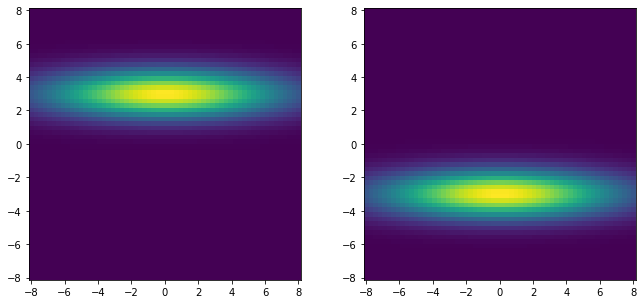

In [8]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plot_grid(get_pdf_grid(source, xrange), xrange)
plt.subplot(1, 2, 2)
plot_grid(get_pdf_grid(target, xrange), xrange)

In [10]:
progress_widget = trange(n_iter)
plot_widget = Output()
display(plot_widget)

try:
    for step in progress_widget:
        x = source.sample((n_samples,)).to(device)
        y = target.sample((n_samples,)).to(device)

        for _ in range(n_mover_iter):
            h_x = mover(x)
            mover_opt.zero_grad()
            mover_loss = l * cost(x, h_x).mean() - critic(h_x).mean()
            mover_loss.backward()
            mover_opt.step()

        critic_opt.zero_grad()
        critic_loss = critic(h_x.detach()).mean() - critic(y).mean()
        critic_loss.backward()
        critic_opt.step()

        with torch.no_grad():
            loss = critic(y).mean() + l * cost(x, h_x).mean() - critic(h_x).mean()
            progress_widget.set_postfix({"loss": loss.item()})

        if step % plot_interval == 0:
            with plot_widget:
                try:
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 10))
                    plt.scatter(*x.detach().cpu().numpy().T,
                                color="blue", label="Source samples", alpha=.5)
                    plt.scatter(*y.detach().cpu().numpy().T,
                                color="green", label="Target samples", alpha=.5)
                    plt.scatter(*h_x.detach().cpu().numpy().T,
                                color="purple", label="Moved samples", alpha=.5)
                    plot_grid(get_critic_grid(critic, xrange), xrange, alpha=.5, cmap=cm.PRGn)
                    plt.legend(loc="upper left")
                    plt.xlim(xrange[:2])
                    plt.ylim(xrange[:2])
                    plt.show()
                except KeyboardInterrupt:
                    break
except KeyboardInterrupt:
    pass

  0%|          | 0/5000 [00:00<?, ?it/s]

Output()

<Figure size 720x720 with 0 Axes>